In [ ]:
import os
import glob
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import kagglehub


# %%
# Automatically download dataset using kagglehub
dataset_path = kagglehub.dataset_download("brsdincer/mars-surface-and-curiosity-image-set-nasa")
image_dir = os.path.join(dataset_path, "additional_images", "calibrated")
print(f"Dataset downloaded to: {dataset_path}")


In [2]:
%pip install kagglehub


In [2]:
# CELL 2 - Define the Dataset Class
import glob
from PIL import Image
from torch.utils.data import Dataset
import os

print("CELL 2: Defining MarsImageDataset...")
class MarsImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        # Look for common image extensions (case-insensitive desirable, but glob might be sensitive)
        extensions = ['*.jpg', '*.JPG', '*.jpeg', '*.JPEG', '*.png', '*.PNG']
        self.image_paths = []
        if not os.path.isdir(self.image_dir):
             print(f"  Error in MarsImageDataset: Directory does not exist: {self.image_dir}")
        else:
            for ext in extensions:
                self.image_paths.extend(glob.glob(os.path.join(self.image_dir, ext)))

        print(f"  MarsImageDataset initialized. Found {len(self.image_paths)} images in {self.image_dir}")
        if not self.image_paths:
             print(f"  WARNING: No images found in {self.image_dir}. Check the path and file extensions.")


    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        try:
            img = Image.open(img_path).convert('RGB') # Ensure 3 channels (RGB)
            if self.transform:
                img = self.transform(img)
            # Return dummy label 0, useful for some unsupervised tasks or if labels aren't needed
            return img, 0
        except Exception as e:
            print(f"Error loading image {img_path}: {e}. Returning None or placeholder.")
            # Handle broken images - returning None might require a custom collate_fn
            # Or return a placeholder tensor of the correct size:
            # return torch.zeros((3, 64, 64)), 0 # Example placeholder if size is 64x64
            # For simplicity, let's try returning the first image if available
            if len(self.image_paths) > 0 and idx != 0:
                return self.__getitem__(0) # Recursively get the first item
            elif len(self.image_paths) > 0 and idx == 0:
                 # If the first image itself is broken, raise error or return placeholder
                 # raise RuntimeError(f"First image {self.image_paths[0]} failed to load.") from e
                 return torch.zeros((3, 512, 512)), 0 # Placeholder
            else:
                 # No images available at all
                 raise RuntimeError("Dataset contains no valid images.") from e

CELL 2: Defining MarsImageDataset...


In [3]:
# CELL 3 - Define transforms, load data, create DataLoaders (FIXED)
import os
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, random_split

print("CELL 3: Setting up transforms and DataLoaders...")

# --- 1. Define the CORRECT image directory ---
# Option A: Use the variable calculated in CELL 1 (if you run CELL 1 right before CELL 3)
# Make sure 'image_dir_from_cell1' exists from CELL 1
# try:
#     image_dir = image_dir_from_cell1
#     if not os.path.isdir(image_dir):
#          raise NameError("image_dir_from_cell1 not found or invalid")
#     print(f"Using image directory from CELL 1: {image_dir}")
# except NameError:
#     print("Variable 'image_dir_from_cell1' not found. Define path manually.")
#     # Fallback: Define path manually (ensure subdirectory is correct!)
base_dataset_path = r"/root/.cache/kagglehub/datasets/brsdincer/mars-surface-and-curiosity-image-set-nasa/versions/1/Mars Surface and Curiosity Image"
# *** VERIFY THIS SUBDIRECTORY by looking in the folder ***
image_subdir = os.path.join("images") # Your original attempt
# image_subdir = os.path.join("mars-surface-and-curiosity-image-set-nasa", "Mars Surface and Curiosity Image Set NASA", "images", "calibrated") # Another possibility
image_dir = os.path.join(base_dataset_path, image_subdir)
print(f"Using manually defined image directory: {image_dir}")


# --- 2. Check if the directory exists ---
if not os.path.isdir(image_dir):
    print(f"\nCRITICAL ERROR: The image directory does NOT exist: {image_dir}")
    print(f"Please check the 'base_dataset_path' and 'image_subdir' variables.")
    print(f"Look inside '{base_dataset_path}' to find the correct subfolder containing images.")
    # Stop execution if path is wrong
    raise FileNotFoundError(f"Image directory not found: {image_dir}")
else:
    print("Image directory confirmed to exist.")
    # Optional: Check for files again here for extra safety
    check_files = glob.glob(os.path.join(image_dir, '*.jpg')) + glob.glob(os.path.join(image_dir, '*.JPG'))
    if not check_files:
        print(f"WARNING: Directory exists, but no .jpg/.JPG files found directly within {image_dir}. Check subfolders or file types.")


# --- 3. Define Transforms ---
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])
print("Transforms defined.")

# --- 4. Load Dataset ---
print("Loading dataset using MarsImageDataset...")
dataset = MarsImageDataset(image_dir, transform=transform)
print(f"Dataset loaded. Number of images found: {len(dataset)}")

# --- 5. Check if dataset is empty ---
if len(dataset) == 0:
    print("\nCRITICAL ERROR: The dataset is empty. MarsImageDataset found 0 images.")
    print(f"Verify the 'image_dir' is correct ({image_dir}) and contains supported image files (.jpg, .png, etc.).")
    print("Also check the MarsImageDataset class in CELL 2 to ensure it finds files correctly.")
    # Stop execution
    raise ValueError("Dataset cannot be empty.")

# --- 6. Split Dataset ---
# Ensure there are enough samples for splitting
if len(dataset) < 2:
    print(f"Warning: Only {len(dataset)} sample(s). Using all for training, none for testing.")
    train_size = len(dataset)
    test_size = 0
    train_ds = dataset
    # Create an empty subset for test_ds if test_size is 0
    test_ds = torch.utils.data.Subset(dataset, [])
else:
    train_size = int(0.8 * len(dataset))
    # Ensure train_size is at least 1 if dataset has items
    if train_size == 0 and len(dataset) > 0:
        train_size = 1
    test_size = len(dataset) - train_size
    print(f"Splitting dataset: Train size = {train_size}, Test size = {test_size}")
    train_ds, test_ds = random_split(dataset, [train_size, test_size])

print(f"Length of train_ds: {len(train_ds)}, Length of test_ds: {len(test_ds)}")

# --- 7. Create DataLoaders (Only if datasets are not empty) ---
train_loader = None
if len(train_ds) > 0:
    # The error originally occurred here because len(train_ds) was 0
    train_loader = DataLoader(train_ds, batch_size=60*3, shuffle=True, num_workers=4) # Set num_workers=0 for easier debugging first
    print(f"Train DataLoader created with {len(train_ds)} samples.")
else:
    print("Train dataset is empty. Skipping Train DataLoader creation.")

test_loader = None
if len(test_ds) > 0:
    test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=0) # Usually shuffle=False for test/validation
    print(f"Test DataLoader created with {len(test_ds)} samples.")
else:
    print("Test dataset is empty. Skipping Test DataLoader creation.")


# --- 8. Define Device and Print Summary ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nDevice: {device}")
print(f"Total Dataset size: {len(dataset)}")
if train_loader:
    print(f"Train loader ready.")
if test_loader:
    print(f"Test loader ready.")

# --- Ready for model training ---

CELL 3: Setting up transforms and DataLoaders...
Using manually defined image directory: /root/.cache/kagglehub/datasets/brsdincer/mars-surface-and-curiosity-image-set-nasa/versions/1/Mars Surface and Curiosity Image/images
Image directory confirmed to exist.
Transforms defined.
Loading dataset using MarsImageDataset...
  MarsImageDataset initialized. Found 6737 images in /root/.cache/kagglehub/datasets/brsdincer/mars-surface-and-curiosity-image-set-nasa/versions/1/Mars Surface and Curiosity Image/images
Dataset loaded. Number of images found: 6737
Splitting dataset: Train size = 5389, Test size = 1348
Length of train_ds: 5389, Length of test_ds: 1348
Train DataLoader created with 5389 samples.
Test DataLoader created with 1348 samples.

Device: cuda
Total Dataset size: 6737
Train loader ready.
Test loader ready.


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [56]:
class GradientLoss(nn.Module):
    """
    Calculates the L1 loss between the gradient magnitudes (Sobel) of the output and target images.
    """
    def __init__(self, device, channels=3):
        super(GradientLoss, self).__init__()
        self.channels = channels
        self.device = device

        # Define Sobel kernels
        kernel_x = torch.tensor([[-1., 0., 1.], [-2., 0., 2.], [-1., 0., 1.]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        kernel_y = torch.tensor([[-1., -2., -1.], [0., 0., 0.], [1., 2., 1.]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)

        # Repeat kernel for each input channel
        kernel_x = kernel_x.repeat(self.channels, 1, 1, 1) # (C, 1, 3, 3)
        kernel_y = kernel_y.repeat(self.channels, 1, 1, 1) # (C, 1, 3, 3)

        # Create non-trainable Conv2d layers
        self.conv_x = nn.Conv2d(in_channels=self.channels, out_channels=self.channels,
                                kernel_size=3, padding=1, bias=False, groups=self.channels)
        self.conv_y = nn.Conv2d(in_channels=self.channels, out_channels=self.channels,
                                kernel_size=3, padding=1, bias=False, groups=self.channels)

        # Load kernels into weights and move to device
        self.conv_x.weight = nn.Parameter(kernel_x, requires_grad=False)
        self.conv_y.weight = nn.Parameter(kernel_y, requires_grad=False)

        self.conv_x.to(device)
        self.conv_y.to(device)

        self.l1_loss = nn.L1Loss()
        self.epsilon = 1e-6 # for numerical stability in sqrt

    def forward(self, output, target):
        """
        Args:
            output (torch.Tensor): The reconstructed image tensor (B, C, H, W).
            target (torch.Tensor): The original image tensor (B, C, H, W).
        Returns:
            torch.Tensor: The gradient L1 loss value.
        """
        if output.device != self.device:
             output = output.to(self.device)
        if target.device != self.device:
             target = target.to(self.device)

        # Calculate gradients for the output image
        grad_x_out = self.conv_x(output)
        grad_y_out = self.conv_y(output)
        grad_mag_out = torch.sqrt(grad_x_out**2 + grad_y_out**2 + self.epsilon)

        # Calculate gradients for the target image
        grad_x_target = self.conv_x(target)
        grad_y_target = self.conv_y(target)
        grad_mag_target = torch.sqrt(grad_x_target**2 + grad_y_target**2 + self.epsilon)

        # Calculate L1 loss between gradient magnitudes
        loss = self.l1_loss(grad_mag_out, grad_mag_target)
        return loss

In [57]:
import torch
import torch.nn as nn

class DropoutAutoencoder(nn.Module):
    def __init__(self, dropout_p): # You can adjust dropout probability
        super(DropoutAutoencoder, self).__init__()
        self.dropout_p = dropout_p

        # --- Encoder ---
        # Input: (B, 3, 512, 512)
        self.encoder = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1), # (B, 64, 256, 256)
            nn.ReLU(inplace=True),
            nn.Dropout(self.dropout_p),

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1), # (B, 128, 128, 128)
            nn.ReLU(inplace=True),
            nn.Dropout(self.dropout_p),

            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1), # (B, 256, 64, 64)
            nn.ReLU(inplace=True),
            nn.Dropout(self.dropout_p),

            # Block 4
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1), # (B, 512, 32, 32)
            nn.ReLU(inplace=True),
            nn.Dropout(self.dropout_p),

            # Block 5
            nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1), # (B, 512, 16, 16)
            nn.ReLU(inplace=True),
            nn.Dropout(self.dropout_p),

            # Block 6 - Bottleneck Layer
            nn.Conv2d(512, 256, kernel_size=3, stride=2, padding=1), # (B, 512, 8, 8)
            nn.ReLU(inplace=True),
            # Optional: Dropout right at the bottleneck too
            # nn.Dropout(self.dropout_p),
        )

        # --- Decoder ---
        # Input: (B, 512, 8, 8)
        self.decoder = nn.Sequential(
            # Block 1
            nn.ConvTranspose2d(256, 512, kernel_size=3, stride=2, padding=1, output_padding=1), # (B, 512, 16, 16)
            nn.ReLU(inplace=True),
            nn.Dropout(self.dropout_p),

            # Block 2
            nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, output_padding=1), # (B, 512, 32, 32)
            nn.ReLU(inplace=True),
            nn.Dropout(self.dropout_p),

            # Block 3
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1), # (B, 256, 64, 64)
            nn.ReLU(inplace=True),
            nn.Dropout(self.dropout_p),

            # Block 4
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1), # (B, 128, 128, 128)
            nn.ReLU(inplace=True),
            nn.Dropout(self.dropout_p),

            # Block 5
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1), # (B, 64, 256, 256)
            nn.ReLU(inplace=True),
            nn.Dropout(self.dropout_p),

            # Block 6 - Output Layer
            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=2, padding=1, output_padding=1), # (B, 3, 512, 512)
            nn.Sigmoid() # Output activation to constrain pixels to [0, 1]
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [58]:
model = DropoutAutoencoder(dropout_p=0.25).to(device)

# %%
# Loss and optimizer
criterion = nn.MSELoss()
gradient_loss_fn = GradientLoss(device=device, channels=3)
lambda_gradient = 0.15
weight_decay_value = 1e-5 # Example value, common range is 1e-4 to 1e-6
learning_rate=6e-4
# --- Choose an Optimizer and add weight_decay ---
# AdamW is often recommended as it handles weight decay correctly



In [59]:
# %% CELL 7 - Modified Training Loop with Gradient Loss (Prints Every Batch Loss)
import torch.optim as optim # Make sure optim is imported

# --- Existing Configuration ---
weight_decay_value = 5e-5 # Example value, common range is 1e-4 to 1e-6
learning_rate=1e-3
num_epochs = 50 # Set the desired number of epochs

# --- Initialize Optimizer ---
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay_value)

# --- Define Loss Functions ---
# Assume 'criterion' is your primary reconstruction loss (e.g., MSE or L1)
# If not defined previously, define it here:
if 'criterion' not in locals():
    print("Warning: 'criterion' (primary loss) not found, defining as MSELoss.")
    criterion = nn.MSELoss() # Or nn.L1Loss()

# Instantiate the Gradient Loss
# Make sure GradientLoss class is defined in a previous cell
# Pass the correct device and number of image channels
gradient_loss_fn = GradientLoss(device=device, channels=3) # Assuming 3 channels (RGB)

# --- Define Gradient Loss Weight (Hyperparameter) ---
lambda_gradient = 0.1 # <<< --- Tune this hyperparameter ---

print("CELL 7: Training Loop with Gradient Loss (Set num_epochs > 0 to run)")

# --- Check if training is possible ---
if 'train_loader' not in locals() or train_loader is None:
    print("Train loader not available. Skipping training loop.")
elif num_epochs <= 0:
    print(f"num_epochs set to {num_epochs}. Skipping training loop.")
else:
    print(f"Starting training for {num_epochs} epochs with Gradient Loss (lambda={lambda_gradient})...")
    model.train() # Set model to training mode

    # --- Epoch Loop ---
    for epoch in range(num_epochs):
        running_total_loss_epoch = 0.0 # Accumulator for combined loss
        running_recon_loss_epoch = 0.0 # Accumulator for reconstruction loss
        running_grad_loss_epoch = 0.0  # Accumulator for gradient loss

        # --- Batch Loop ---
        for i, (imgs, _) in enumerate(train_loader): # 'i' is the batch index
            # --- Step 1: Move input data to the target device ---
            imgs = imgs.to(device)

            # --- Step 2: Forward pass ---
            outputs = model(imgs)

            # --- Step 3: Calculate individual losses ---
            loss_recon = criterion(outputs, imgs)
            loss_grad = gradient_loss_fn(outputs, imgs)

            # --- Step 4: Combine losses ---
            total_loss = loss_recon + lambda_gradient * loss_grad

            # --- Step 5: Backpropagation ---
            optimizer.zero_grad()       # Clears gradients
            total_loss.backward()       # Computes gradients for the combined loss
            optimizer.step()            # Updates model parameters

            # --- Logging & Accumulation ---
            batch_total_loss = total_loss.item()
            batch_recon_loss = loss_recon.item()
            batch_grad_loss = loss_grad.item()

            # Accumulate weighted losses for epoch average
            running_total_loss_epoch += batch_total_loss * imgs.size(0)
            running_recon_loss_epoch += batch_recon_loss * imgs.size(0)
            running_grad_loss_epoch += batch_grad_loss * imgs.size(0)

            # *** Print Loss for EVERY Batch ***
            print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{i+1}/{len(train_loader)}], '
                  f'Total Loss: {batch_total_loss:.4f} '
                  f'(Recon: {batch_recon_loss:.4f}, Grad: {batch_grad_loss:.4f})')

        # --- End of Epoch ---
        # Calculate average losses for the epoch using len(train_ds) or equivalent dataset size
        dataset_size = len(train_loader.dataset) # Assumes train_loader has dataset attribute
        avg_total_loss = running_total_loss_epoch / dataset_size
        avg_recon_loss = running_recon_loss_epoch / dataset_size
        avg_grad_loss = running_grad_loss_epoch / dataset_size

        print(f'--- Epoch {epoch+1} Completed. Avg Losses -> '
              f'Total: {avg_total_loss:.4f} '
              f'(Recon: {avg_recon_loss:.4f}, Grad: {avg_grad_loss:.4f}) ---')


    print("Training finished.")
    # Optional: Save the trained model weights
    # torch.save(model.state_dict(), 'dropout_autoencoder_mars_512_trained_gradloss.pth')
    # print("Model weights saved.")

print("-" * 30)

# --- Important: Set model back to evaluation mode after training ---
model.eval()
print("Model set to evaluation mode (model.eval()). Ready for inference.")
print("-" * 30)

# Now you can proceed with subsequent cells using the trained model.

CELL 7: Training Loop with Gradient Loss (Set num_epochs > 0 to run)
Starting training for 50 epochs with Gradient Loss (lambda=0.1)...
Epoch [1/50], Batch [1/30], Total Loss: 0.0560 (Recon: 0.0379, Grad: 0.1816)
Epoch [1/50], Batch [2/30], Total Loss: 0.0614 (Recon: 0.0437, Grad: 0.1771)
Epoch [1/50], Batch [3/30], Total Loss: 0.0541 (Recon: 0.0367, Grad: 0.1740)
Epoch [1/50], Batch [4/30], Total Loss: 0.0569 (Recon: 0.0406, Grad: 0.1630)
Epoch [1/50], Batch [5/30], Total Loss: 0.0537 (Recon: 0.0379, Grad: 0.1580)
Epoch [1/50], Batch [6/30], Total Loss: 0.0545 (Recon: 0.0388, Grad: 0.1570)
Epoch [1/50], Batch [7/30], Total Loss: 0.0544 (Recon: 0.0381, Grad: 0.1636)
Epoch [1/50], Batch [8/30], Total Loss: 0.0562 (Recon: 0.0399, Grad: 0.1628)
Epoch [1/50], Batch [9/30], Total Loss: 0.0551 (Recon: 0.0393, Grad: 0.1586)
Epoch [1/50], Batch [10/30], Total Loss: 0.0549 (Recon: 0.0394, Grad: 0.1551)
Epoch [1/50], Batch [11/30], Total Loss: 0.0522 (Recon: 0.0373, Grad: 0.1492)
Epoch [1/50], B

KeyboardInterrupt: 

In [72]:
# Save the trained model to a file
model_filename = "martiannet_autoencoder.pth"
torch.save(model.state_dict(), model_filename)
print(f"Model saved to {model_filename}")


Model saved to martiannet_autoencoder.pth


In [61]:
def enable_dropout(model):
    """Enables dropout layers during inference for MC Dropout."""
    for m in model.modules():
        if isinstance(m, torch.nn.Dropout) or isinstance(m, torch.nn.Dropout2d):
            m.train()

model.eval()  # Start by putting the model in eval mode
enable_dropout(model)  # Then activate dropout layers


In [73]:
import torch

def predict_mc_dropout(model, input_tensor, T=170):
    """
    Performs Monte Carlo Dropout predictions.

    Args:
        model: PyTorch model with dropout layers.
        input_tensor: Single image or batch of images, shape (B, C, H, W)
        T: Number of MC dropout forward passes

    Returns:
        mean_pred: Mean prediction across T passes, shape (B, C, H, W)
        variance_pred: Variance across T passes, shape (B, C, H, W)
    """
    model.eval()
    enable_dropout(model)  # Crucial step

    preds = []

    # Perform T stochastic forward passes
    with torch.no_grad():
        for _ in range(T):
            pred = model(input_tensor)
            preds.append(pred.unsqueeze(0))  # Add new dimension at 0 for stacking later

    # Stack predictions along new dimension (T, B, C, H, W)
    preds_tensor = torch.cat(preds, dim=0)

    # Compute mean and variance across T passes (dimension 0)
    mean_pred = preds_tensor.mean(dim=0)
    variance_pred = preds_tensor.var(dim=0, unbiased=False)

    return mean_pred, variance_pred


In [87]:
import random
random_idx = random.randint(0, len(test_ds) - 1)
print(f"Loading random sample index: {random_idx} from test_ds (size: {len(test_ds)})")

# Retrieve the image tensor and its dummy label from the dataset
# Note: test_ds[idx] returns the raw item BEFORE batching
sample_img_tensor, _ = test_ds[random_idx] # Assuming dataset returns (image, label)

# Add the batch dimension (B=1) as the model expects (B, C, H, W)
# and move the single image batch to the correct device
sample_img = sample_img_tensor.unsqueeze(0).to(device)

mean_pred, uncertainty = predict_mc_dropout(model, sample_img, T=40)

# Convert for plotting
original = sample_img.squeeze().permute(1, 2, 0).cpu().numpy()
reconstructed = mean_pred.squeeze().permute(1, 2, 0).cpu().numpy()
uncertainty_map = uncertainty.squeeze().mean(dim=0).cpu().numpy()
absolute_error = torch.abs(sample_img - mean_pred) # Shape: (1, C, H, W)
# Sum error across channels for a single heatmap per image
pixel_error = torch.sum(absolute_error, dim=1) # Shape: (1, H, W)
print(f"Pixel error map shape (summed): {pixel_error.shape}")
error_map = pixel_error.squeeze(0).cpu().numpy()

Loading random sample index: 1019 from test_ds (size: 1348)
Pixel error map shape (summed): torch.Size([1, 256, 256])


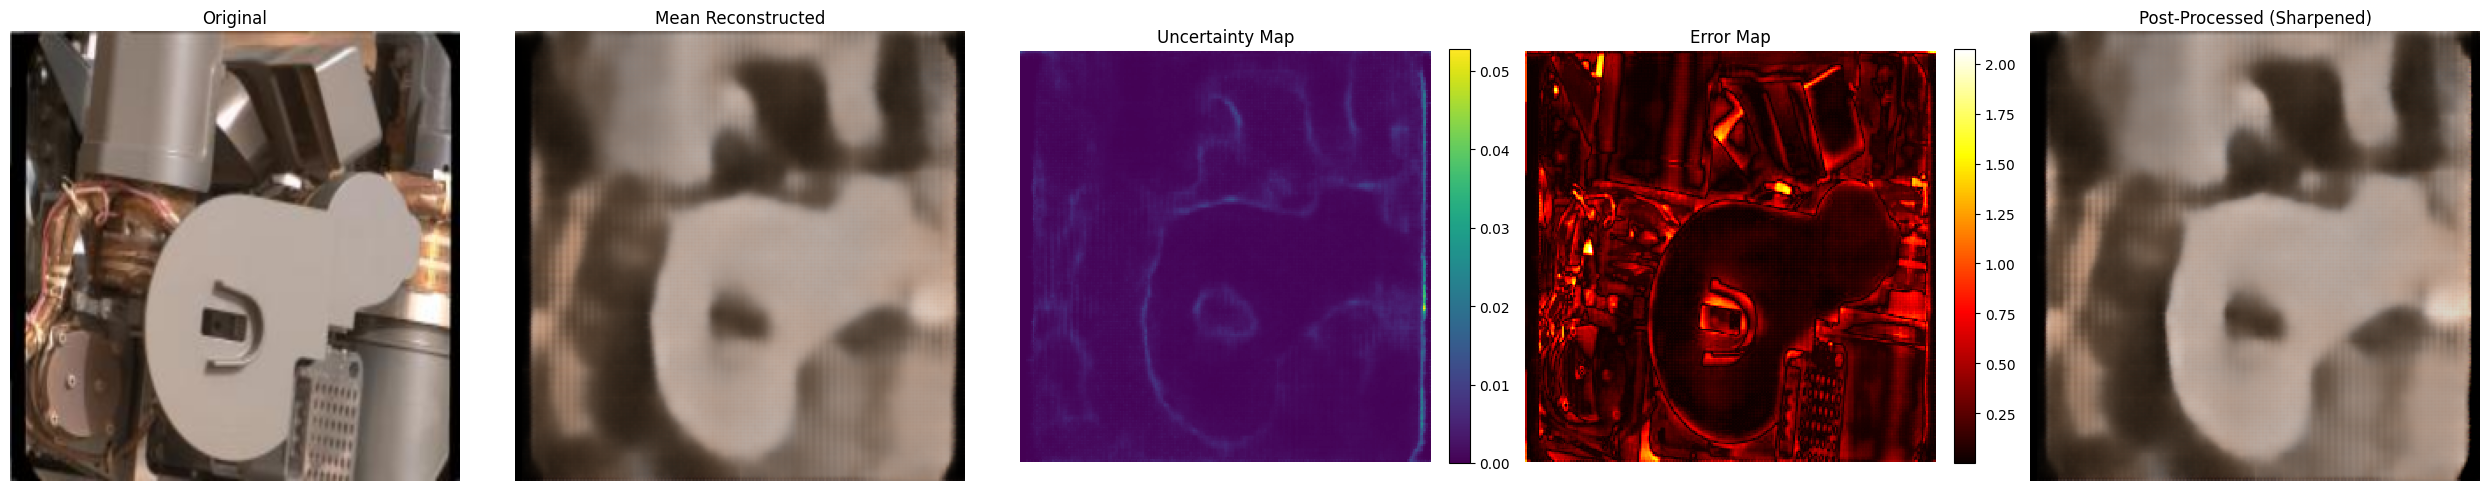

In [88]:
import matplotlib.pyplot as plt
import numpy as np # Make sure numpy is imported
from scipy.ndimage import gaussian_filter # For blurring in unsharp mask

# --- Assume these variables are already populated ---
# original: numpy array for the original image (H, W, C), range [0, 1] or [0, 255]
# reconstructed: numpy array for the mean reconstructed image (H, W, C), range [0, 1] or [0, 255]
# uncertainty_map: numpy array for the uncertainty heatmap (H, W), positive values
# error_map: numpy array for the error heatmap (H, W), positive values
# --- End Assumptions ---

# --- Ensure inputs are float for calculations, especially if original images were uint8 ---
original = original.astype(np.float32)
reconstructed = reconstructed.astype(np.float32)
uncertainty_map = uncertainty_map.astype(np.float32)
error_map = error_map.astype(np.float32)

# --- Configuration for Post-Processing ---
gaussian_sigma = 8        # Sigma for Gaussian blur (controls smoothness)
max_sharpen_strength = 5  # Maximum sharpening factor where uncertainty is highest

# --- 1. Normalize Uncertainty Map to [0, 1] ---
# Handle case where max uncertainty might be zero to avoid division by zero
max_uncertainty = np.max(uncertainty_map)
if max_uncertainty > 1e-6: # Use a small epsilon for float comparison
    normalized_uncertainty = uncertainty_map / max_uncertainty
else:
    normalized_uncertainty = np.zeros_like(uncertainty_map)

# --- 2. Create Sharpening Amount Map ---
# This map (H, W) determines how much sharpening to apply at each pixel
sharpening_amount_map = max_sharpen_strength * normalized_uncertainty

# --- 3. Apply Unsharp Masking ---
# a) Create a blurred version of the reconstructed image
# Apply Gaussian filter channel-wise (sigma is 0 for the channel axis)
blurred_reconstructed = gaussian_filter(reconstructed, sigma=(gaussian_sigma, gaussian_sigma, 0))

# b) Calculate the "details" (high-frequency components)
details = reconstructed - blurred_reconstructed

# c) Add details back, scaled by the sharpening amount map
# We need to reshape the sharpening map to (H, W, 1) to broadcast correctly with (H, W, C) details
sharpening_amount_map_3d = sharpening_amount_map[..., np.newaxis]
post_processed = reconstructed + sharpening_amount_map_3d * details

# --- 4. Clip Post-Processed Image ---
# Ensure pixel values stay within the valid range (e.g., [0, 1] if input was normalized, or [0, 255])
# Determine range from original or reconstructed assuming they have the same scale
min_val = np.min(reconstructed) # Could be 0
max_val = np.max(reconstructed) # Could be 1 or 255
post_processed_clipped = np.clip(post_processed, min_val, max_val)


# --- Plotting ---
fig, ax = plt.subplots(1, 5, figsize=(25, 5)) # Increased to 5 subplots

# --- Plot Original Image ---
# Display requires clipping or ensuring the range is valid for imshow (e.g., [0,1] for float)
ax[0].imshow(np.clip(original, min_val, max_val) / max_val if max_val > 1 else np.clip(original, 0, 1))
ax[0].set_title("Original")
ax[0].axis("off")

# --- Plot Reconstructed Image ---
ax[1].imshow(np.clip(reconstructed, min_val, max_val) / max_val if max_val > 1 else np.clip(reconstructed, 0, 1))
ax[1].set_title("Mean Reconstructed")
ax[1].axis("off")

# --- Plot Uncertainty Map ---
im_unc = ax[2].imshow(uncertainty_map, cmap='viridis', interpolation='nearest')
ax[2].set_title("Uncertainty Map")
ax[2].axis("off")
fig.colorbar(im_unc, ax=ax[2], fraction=0.046, pad=0.04)

# --- Plot Error Map ---
im_err = ax[3].imshow(error_map, cmap='hot', interpolation='nearest')
ax[3].set_title("Error Map")
ax[3].axis("off")
fig.colorbar(im_err, ax=ax[3], fraction=0.046, pad=0.04)

# --- Plot Post-Processed (Sharpened) Image ---
ax[4].imshow(post_processed_clipped / max_val if max_val > 1 else post_processed_clipped)
ax[4].set_title("Post-Processed (Sharpened)")
ax[4].axis("off")


# --- Adjust layout and display ---
plt.tight_layout()
plt.show()

In [82]:
import os
import random
import torch
import numpy as np
from scipy.ndimage import gaussian_filter
import itertools # For grid search combinations

# --- Assume these variables/functions are already defined and available ---
# model: Your trained PyTorch model
# test_ds: Your test dataset
# device: Your torch device ('cuda' or 'cpu')
# enable_dropout(model): Function to enable dropout layers during eval
# predict_mc_dropout(model, input_tensor, T): Function for MC Dropout inference
# --- End Assumptions ---

# --- Grid Search Configuration ---
sigmas_to_try = [1, 2, 3, 4, 6, 8]  # Example values for gaussian_sigma
strengths_to_try = [0.5, 1, 2, 3, 5, 7] # Example values for max_sharpen_strength
num_eval_images = 40 # Number of random images to evaluate on
mc_dropout_iterations = 100 # T value for MC Dropout

# --- Helper Function for Post-Processing ---
def apply_postprocessing(reconstructed_np, uncertainty_map_np, sigma, strength):
    """Applies the unsharp masking based on uncertainty."""
    reconstructed_np = reconstructed_np.astype(np.float32)
    uncertainty_map_np = uncertainty_map_np.astype(np.float32)

    # Normalize Uncertainty
    max_uncertainty = np.max(uncertainty_map_np)
    if max_uncertainty > 1e-6:
        normalized_uncertainty = uncertainty_map_np / max_uncertainty
    else:
        normalized_uncertainty = np.zeros_like(uncertainty_map_np)

    # Sharpening Map
    sharpening_amount_map = strength * normalized_uncertainty

    # Unsharp Masking
    blurred_reconstructed = gaussian_filter(reconstructed_np, sigma=(sigma, sigma, 0))
    details = reconstructed_np - blurred_reconstructed
    sharpening_amount_map_3d = sharpening_amount_map[..., np.newaxis]
    post_processed = reconstructed_np + sharpening_amount_map_3d * details

    # Clip (assuming [0, 1] range)
    post_processed_clipped = np.clip(post_processed, 0.0, 1.0)
    return post_processed_clipped

# --- Grid Search Execution ---
results = {} # Dictionary to store { (sigma, strength): total_mse }
best_mse = float('inf')
best_params = (None, None)

# Select random images
if len(test_ds) < num_eval_images:
    print(f"Warning: Requested {num_eval_images} images, but dataset only has {len(test_ds)}. Using all images.")
    num_eval_images = len(test_ds)
    sample_indices = list(range(len(test_ds)))
else:
    sample_indices = random.sample(range(len(test_ds)), num_eval_images)

print(f"Starting grid search over {len(sigmas_to_try)} sigmas and {len(strengths_to_try)} strengths using {num_eval_images} images...")

model.eval()
enable_dropout(model)

# Pre-calculate reconstructions for the evaluation images (avoids re-running inference)
eval_data = []
with torch.no_grad():
    for idx in sample_indices:
        sample_img_tensor, _ = test_ds[idx]
        sample_img = sample_img_tensor.unsqueeze(0).to(device)
        mean_pred, uncertainty = predict_mc_dropout(model, sample_img, T=mc_dropout_iterations)

        original_np = sample_img.squeeze(0).permute(1, 2, 0).cpu().numpy()
        reconstructed_np = mean_pred.squeeze(0).permute(1, 2, 0).cpu().numpy()
        if uncertainty.shape[1] > 1:
            uncertainty_map_np = uncertainty.squeeze(0).mean(dim=0).cpu().numpy()
        else:
            uncertainty_map_np = uncertainty.squeeze(0).squeeze(0).cpu().numpy()

        eval_data.append({
            "original": original_np,
            "reconstructed": reconstructed_np,
            "uncertainty": uncertainty_map_np
        })
        print(f"  Pre-calculated inference for image index {idx}")


# Iterate through hyperparameter combinations
param_combinations = list(itertools.product(sigmas_to_try, strengths_to_try))
total_combinations = len(param_combinations)

for i, (sigma, strength) in enumerate(param_combinations):
    total_mse_for_combo = 0.0
    # Evaluate this combo on all selected images
    for data in eval_data:
        post_processed_clipped = apply_postprocessing(data["reconstructed"], data["uncertainty"], sigma, strength)
        mse = np.mean((data["original"] - post_processed_clipped) ** 2)
        total_mse_for_combo += mse

    average_mse = total_mse_for_combo / num_eval_images
    results[(sigma, strength)] = average_mse

    print(f"  [{i+1}/{total_combinations}] Sigma={sigma}, Strength={strength} -> Avg MSE: {average_mse:.6f}")

    if average_mse < best_mse:
        best_mse = average_mse
        best_params = (sigma, strength)

print("\n--- Grid Search Complete ---")
print(f"Best Parameters Found:")
print(f"  Gaussian Sigma: {best_params[0]}")
print(f"  Max Sharpen Strength: {best_params[1]}")
print(f"  Lowest Average MSE: {best_mse:.6f}")

# You can now use best_params[0] and best_params[1] in your main script
# Example:
# gaussian_sigma = best_params[0]
# max_sharpen_strength = best_params[1]

Starting grid search over 6 sigmas and 6 strengths using 40 images...
  Pre-calculated inference for image index 327
  Pre-calculated inference for image index 711
  Pre-calculated inference for image index 475
  Pre-calculated inference for image index 425
  Pre-calculated inference for image index 321
  Pre-calculated inference for image index 354
  Pre-calculated inference for image index 455
  Pre-calculated inference for image index 952
  Pre-calculated inference for image index 807
  Pre-calculated inference for image index 803
  Pre-calculated inference for image index 600
  Pre-calculated inference for image index 192
  Pre-calculated inference for image index 247
  Pre-calculated inference for image index 916
  Pre-calculated inference for image index 250
  Pre-calculated inference for image index 129
  Pre-calculated inference for image index 541
  Pre-calculated inference for image index 569
  Pre-calculated inference for image index 741
  Pre-calculated inference for image 

KeyboardInterrupt: 

In [71]:
import os
import random
import torch
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter # <-- Import gaussian_filter

# --- Assume these functions/variables are defined elsewhere ---
# model: Your trained PyTorch model
# test_ds: Your test dataset
# device: Your torch device ('cuda' or 'cpu')
# enable_dropout(model): Function to enable dropout layers during eval
# predict_mc_dropout(model, input_tensor, T): Function for MC Dropout inference
# --- End Assumptions ---

# --- Configuration for Post-Processing ---
gaussian_sigma = 8        # Sigma for Gaussian blur (controls smoothness) - Adjust as needed
max_sharpen_strength = 0.5  # Maximum sharpening factor where uncertainty is highest - Adjust as needed

# Create output directory if it doesn't exist
output_dir = "halfabitperpixel" # Changed name slightly
os.makedirs(output_dir, exist_ok=True)

# Enable dropout for MC sampling
model.eval()
enable_dropout(model) # Make sure this function correctly sets dropout layers to train() mode

# How many images to sample
num_samples = 140 # Keep the original number, or change if needed
sample_indices = random.sample(range(len(test_ds)), num_samples)

print(f"Starting inference and post-processing for {num_samples} samples...")

for i, idx in enumerate(sample_indices):
    # --- 1. Load and preprocess image ---
    sample_img_tensor, _ = test_ds[idx]
    sample_img = sample_img_tensor.unsqueeze(0).to(device)

    # --- 2. MC Dropout inference ---
    # Ensure predict_mc_dropout returns tensors on the CPU or move them later
    with torch.no_grad(): # Good practice for inference
        mean_pred, uncertainty = predict_mc_dropout(model, sample_img, T=40)

    # --- 3. Prepare image data (convert tensors to numpy) ---
    # Ensure data is in the expected format (H, W, C) for images, (H, W) for maps
    # Assuming input/output tensors are CHW and normalized to [0, 1]
    original_np = sample_img.squeeze(0).permute(1, 2, 0).cpu().numpy()
    reconstructed_np = mean_pred.squeeze(0).permute(1, 2, 0).cpu().numpy()

    # Assuming uncertainty is (C, H, W) or (1, H, W), calculate mean uncertainty per pixel
    if uncertainty.shape[1] > 1: # If uncertainty has channel dimension
         uncertainty_map_np = uncertainty.squeeze(0).mean(dim=0).cpu().numpy()
    else: # If uncertainty is already (1, H, W)
         uncertainty_map_np = uncertainty.squeeze(0).squeeze(0).cpu().numpy()

    # Calculate Error Map (L1 error summed across channels)
    absolute_error = torch.abs(sample_img - mean_pred) # Still on device
    error_map_np = torch.sum(absolute_error, dim=1).squeeze(0).cpu().numpy()

    # --- 4. Apply Post-Processing (Uncertainty-Guided Sharpening) ---

    # Ensure inputs are float32 for calculations
    original_np = original_np.astype(np.float32)
    reconstructed_np = reconstructed_np.astype(np.float32)
    uncertainty_map_np = uncertainty_map_np.astype(np.float32)
    # error_map_np is already float from PyTorch

    # a) Normalize Uncertainty Map to [0, 1]
    max_uncertainty = np.max(uncertainty_map_np)
    if max_uncertainty > 1e-6: # Avoid division by zero
        normalized_uncertainty = uncertainty_map_np / max_uncertainty
    else:
        normalized_uncertainty = np.zeros_like(uncertainty_map_np)

    # b) Create Sharpening Amount Map
    sharpening_amount_map = max_sharpen_strength * normalized_uncertainty

    # c) Apply Unsharp Masking
    # Blurred version (apply channel-wise)
    blurred_reconstructed = gaussian_filter(reconstructed_np, sigma=(gaussian_sigma, gaussian_sigma, 0))
    # Details
    details = reconstructed_np - blurred_reconstructed
    # Add details back, scaled by sharpening map
    # Reshape sharpening map for broadcasting: (H, W) -> (H, W, 1)
    sharpening_amount_map_3d = sharpening_amount_map[..., np.newaxis]
    post_processed = reconstructed_np + sharpening_amount_map_3d * details

    # d) Clip Post-Processed Image
    # Assuming data range is [0, 1] as is common in ML pipelines
    post_processed_clipped = np.clip(post_processed, 0.0, 1.0)

    # --- 5. Plotting ---
    fig, ax = plt.subplots(1, 5, figsize=(25, 5)) # Changed to 5 subplots

    # Plot Original
    # Clip original just in case, although it should be in range
    ax[0].imshow(np.clip(original_np, 0.0, 1.0))
    ax[0].set_title("Original")
    ax[0].axis("off")

    # Plot Reconstructed
    # Clip reconstructed just in case
    ax[1].imshow(np.clip(reconstructed_np, 0.0, 1.0))
    ax[1].set_title("Mean Reconstructed")
    ax[1].axis("off")

    # Plot Uncertainty Map
    im_unc = ax[2].imshow(uncertainty_map_np, cmap='viridis', interpolation='nearest')
    ax[2].set_title("Uncertainty Map")
    ax[2].axis("off")
    fig.colorbar(im_unc, ax=ax[2], fraction=0.046, pad=0.04)

    # Plot Error Map
    im_err = ax[3].imshow(error_map_np, cmap='hot', interpolation='nearest')
    ax[3].set_title("Error Map")
    ax[3].axis("off")
    fig.colorbar(im_err, ax=ax[3], fraction=0.046, pad=0.04)

    # Plot Post-Processed (Sharpened) Image
    ax[4].imshow(post_processed_clipped) # Already clipped to [0, 1]
    ax[4].set_title("Post-Processed (Sharpened)")
    ax[4].axis("off")

    # --- 6. Save and Cleanup ---
    plt.tight_layout()
    output_path = os.path.join(output_dir, f"sample_{idx:04d}_postprocessed.png") # Use index 'idx' for consistency?
    plt.savefig(output_path)
    plt.close(fig) # Close the figure to free memory

    # Optional: Clear variables if memory becomes an issue (less common now)
    # del original_np, reconstructed_np, uncertainty_map_np, error_map_np
    # del blurred_reconstructed, details, post_processed, post_processed_clipped
    # torch.cuda.empty_cache() # If using GPU

    print(f"[{i+1}/{num_samples}] Saved: {output_path}")

print("Finished processing all samples.")
import shutil; shutil.make_archive(output_dir, 'zip', output_dir)

Starting inference and post-processing for 140 samples...
[1/140] Saved: halfabitperpixel/sample_1039_postprocessed.png
[2/140] Saved: halfabitperpixel/sample_0928_postprocessed.png
[3/140] Saved: halfabitperpixel/sample_0478_postprocessed.png
[4/140] Saved: halfabitperpixel/sample_0940_postprocessed.png
[5/140] Saved: halfabitperpixel/sample_1308_postprocessed.png
[6/140] Saved: halfabitperpixel/sample_0462_postprocessed.png
[7/140] Saved: halfabitperpixel/sample_0667_postprocessed.png
[8/140] Saved: halfabitperpixel/sample_0794_postprocessed.png
[9/140] Saved: halfabitperpixel/sample_0357_postprocessed.png
[10/140] Saved: halfabitperpixel/sample_0019_postprocessed.png
[11/140] Saved: halfabitperpixel/sample_0452_postprocessed.png
[12/140] Saved: halfabitperpixel/sample_1087_postprocessed.png
[13/140] Saved: halfabitperpixel/sample_0112_postprocessed.png
[14/140] Saved: halfabitperpixel/sample_0965_postprocessed.png
[15/140] Saved: halfabitperpixel/sample_1108_postprocessed.png
[16/14

'/content/halfabitperpixel.zip'

In [ ]:
import os
# import random # No longer needed
import torch
import matplotlib.pyplot as plt # Still needed for imsave
import numpy as np

# --- Assumed Setup (Make sure these are defined correctly in your environment) ---
# model: Your trained PyTorch model
# test_ds: Your PyTorch test dataset (e.g., torchvision.datasets.CIFAR10(..., train=False))
# device: The device to run inference on (e.g., torch.device("cuda" if torch.cuda.is_available() else "cpu"))
# enable_dropout(model): A function that enables dropout layers during model.eval() for MC Dropout
# predict_mc_dropout(model, input_tensor, T): A function performing T forward passes with dropout enabled
#                                             and returning mean prediction (and optionally uncertainty).
# -----------------------------------------------------------------------------------

# Create output directory if it doesn't exist
output_dir = "reconstructed_images" # Changed directory name
os.makedirs(output_dir, exist_ok=True)

# Enable dropout for MC sampling (Assuming this function exists)
# Make sure model is in eval mode for consistent dropout behavior during inference
model.eval()
try:
    enable_dropout(model) # Ensure this function correctly sets dropout layers to training mode within eval context if needed for MC Dropout
except NameError:
    print("Warning: 'enable_dropout' function not found. Ensure dropout is active for MC sampling if required.")
    # Add alternative logic here if needed

# Determine the total number of images in the test dataset
total_images = len(test_ds)
print(f"Processing all {total_images} images in the test dataset to save reconstructions...")

# Iterate through ALL indices in the test dataset
for i, idx in enumerate(range(total_images)):
    try:
        # Load and preprocess image
        # Assuming test_ds returns (image_tensor, label)
        sample_img_tensor, _ = test_ds[idx]
        # Add batch dimension and move to the correct device
        sample_img = sample_img_tensor.unsqueeze(0).to(device)

        # MC Dropout inference (Assuming this function exists)
        # T=40 means 40 forward passes per image
        # We only need the mean prediction now
        try:
            # Modify this line based on what predict_mc_dropout returns
            # Option 1: It returns mean and uncertainty
            mean_pred, _ = predict_mc_dropout(model, sample_img, T=40)
            # Option 2: It only returns the mean prediction
            # mean_pred = predict_mc_dropout(model, sample_img, T=40)
        except NameError:
             print(f"Error: 'predict_mc_dropout' function not found. Cannot perform inference for image index {idx}.")
             continue # Skip to next image if prediction function is missing
        except TypeError: # Handle case where function returns only one value
             print("Note: 'predict_mc_dropout' seems to return only one value (assuming it's the mean prediction).")
             mean_pred = predict_mc_dropout(model, sample_img, T=40)


        # Prepare reconstructed image data for saving
        # Squeeze removes the batch dimension, permute changes channel order (C, H, W) -> (H, W, C)
        # Move to CPU and convert to NumPy array
        reconstructed_img_np = mean_pred.squeeze(0).permute(1, 2, 0).cpu().numpy()

        # Clip values to the valid range [0, 1] for saving as an image
        reconstructed_img_np_clipped = np.clip(reconstructed_img_np, 0, 1)

        # Define output path using the loop counter 'i'
        # Pad with zeros based on total images for correct sorting
        output_filename = f"reconstructed_{i+1:0{len(str(total_images))}d}.png"
        output_path = os.path.join(output_dir, output_filename)

        # Save the reconstructed image using matplotlib.pyplot.imsave
        # imsave automatically handles scaling if data is float [0,1] or int [0,255]
        plt.imsave(output_path, reconstructed_img_np_clipped)

        # Update progress message
        if (i + 1) % 100 == 0 or i == total_images - 1: # Print progress every 100 images or on the last image
            print(f"[{i+1}/{total_images}] Saved: {output_path}")

    except Exception as e:
        print(f"Error processing image index {idx} (Iteration {i+1}): {e}")
        # continue # Continue to the next image even if one fails

print(f"\nFinished saving {total_images} reconstructed images to '{output_dir}'.")

Processing all 2695 images in the test dataset to save reconstructions...
[100/2695] Saved: reconstructed_images\reconstructed_0100.png
[200/2695] Saved: reconstructed_images\reconstructed_0200.png
[300/2695] Saved: reconstructed_images\reconstructed_0300.png
[400/2695] Saved: reconstructed_images\reconstructed_0400.png
[500/2695] Saved: reconstructed_images\reconstructed_0500.png
[600/2695] Saved: reconstructed_images\reconstructed_0600.png
[700/2695] Saved: reconstructed_images\reconstructed_0700.png
[800/2695] Saved: reconstructed_images\reconstructed_0800.png
[900/2695] Saved: reconstructed_images\reconstructed_0900.png
[1000/2695] Saved: reconstructed_images\reconstructed_1000.png
[1100/2695] Saved: reconstructed_images\reconstructed_1100.png
[1200/2695] Saved: reconstructed_images\reconstructed_1200.png
[1300/2695] Saved: reconstructed_images\reconstructed_1300.png
[1400/2695] Saved: reconstructed_images\reconstructed_1400.png
[1500/2695] Saved: reconstructed_images\reconstructed